<a href="https://colab.research.google.com/github/geunwoobaek/MelonRecommandService/blob/master/Geunwoo_jpynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re
import itertools
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import linear_kernel

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.manifold import TSNE
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label,HoverTool
from bokeh.io import output_notebook, show
from bokeh.plotting import figure,output_file
from bokeh.palettes import brewer



pd.options.mode.chained_assignment = None

In [0]:
torch.cuda.is_available()

True

In [0]:
pd.options.mode.chained_assignment = None

In [0]:
genre_gn_all = pd.read_json('/content/drive/My Drive/genre_gn_all.json', typ = 'series')
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

In [0]:
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])
# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')
gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-
...,...,...,...,...
220,GN2800,뮤직테라피,GN2806,반려동물
221,GN2900,뮤지컬,GN2901,세부장르전체
222,GN2900,뮤지컬,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN2903,국외뮤지컬


In [0]:
song_meta = pd.read_json('/content/drive/My Drive/song_meta.json')

In [0]:
song_meta.id['id'].apply(str)

0              0
1              1
2              2
3              3
4              4
           ...  
707984    707984
707985    707985
707986    707986
707987    707987
707988    707988
Name: id, Length: 707989, dtype: int64

In [0]:
song_meta.head(5)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


In [0]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]
# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)
# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

In [0]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

# 3. 2번 테이블에 비율 값 추가
gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.69
1,2,92378,13.07
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54609 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46108 missing from current font.
  font.set_

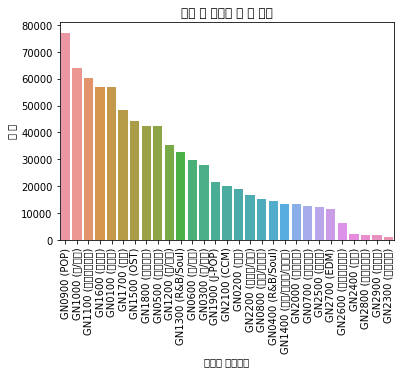

In [0]:
# 1. 장르 별 곡 수 count 테이블 생성 : gnr_count
gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')

# 2. 1번 테이블과 장르 meta와 join
gnr_count = pd.merge(gnr_count, gnr_code.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'

# 3. 매핑이 되지 않은 일부 곡들은 제거
gnr_count = gnr_count[['gnr_code_name', 'song_cnt']].dropna()

# 4. 많은 곡이 매핑된 순 기준으로 내림차순 리스트 생성
gnr_list_desc = gnr_count.sort_values('song_cnt', ascending = False).gnr_code_name

# 5. plotting
gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = gnr_count, order = gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

# 해야할 것  playlist에서 노래 100개와 tag 10개 예측

1. playlist 별 노래들의 장르 분포 계산하는 함수 구현

-> 장르분포가 비슷한 playlist 와 유사성 비교하기 위해
  아마 장르 분포가 비슷한 playlist 는 비슷한 tag를 가지고 있을것임

2. 각 playlist 에서 상위 25개 ( 위 그래프 참고 ) 의 노래 장르의 비율 계산하는 함수 구현

# 공간으로 구분하는건 불가능할거 같음


# 1. playlist 별 노래들의 장르 분포 계산하는 함수

In [0]:
train_df = pd.read_json('/content/drive/My Drive/train.json',)


In [0]:
train_df['updt_date']=pd.to_datetime(train_df['updt_date'],format='%Y-%m-%d %H:%M:%S', errors='raise')

In [0]:
song_meta.query("artist_id_basket in 5562")

TypeError: ignored

In [0]:
train_df

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42


In [0]:
song_meta

In [0]:
testcase = np.array(song_meta['artist_id_basket'][0], dtype=np.int32)

In [0]:
df_INNER_JOIN = pd.merge(song_meta, train_df[0], left_on='id'', right_on='id', how='inner')

SyntaxError: ignored

In [0]:

df=pd.DataFrame(train_df, columns=['songs'])

In [0]:
lendf=df["songs"].apply(lambda x: len(x))

In [0]:
lendf

0          19
1          42
2          28
3          38
4          53
         ... 
115066     12
115067     11
115068     11
115069     55
115070    200
Name: songs, Length: 115071, dtype: int64

In [0]:
train_df.head(10000).to_csv('melon.csv',encoding='utf-8-sig')

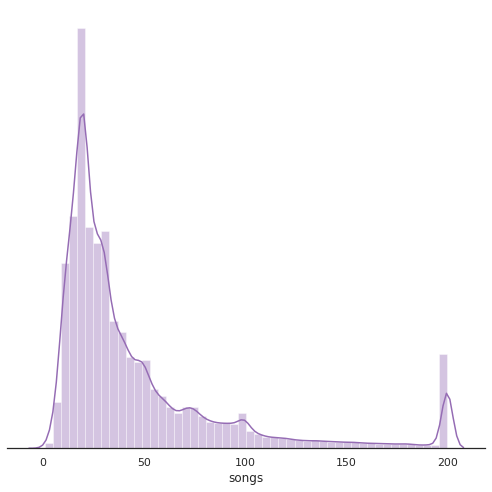

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)

# Set up the matplotlib figure
f, axes = plt.subplots(1, 1, figsize=(7, 7), sharex=True)
sns.despine(left=True)

# Generate a random univariate dataset
d = rs.normal(size=100)
# Plot a histogram and kernel density estimate
sns.distplot(lendf, color="m")

plt.setp(axes, yticks=[])
plt.tight_layout()

In [0]:
train_100_sam=train_df.head(100)

In [0]:
import multiprocessing
import time


song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket','song_gn_dtl_gnr_basket']]
gnr_list=[]
dtl_list=[]
encoding_list=[]
encoding_table_list=[]

def cal_gnr_dtl(x):
  # train_df 에서 song id list 만 가져오면 x-> list 
  id_list=x
  #print("now song number =",len(x))

  cur_gnr_list=[]
  cur_dtl_list=[]
  for song_id in id_list: # 노래에 해당하는 장르를 가져와 리스트로 만듬
    #print(song_id)
    cur_gnr=np.concatenate(song_gnr_map[song_gnr_map.id==song_id].song_gn_gnr_basket.values)
    cur_dtl=np.concatenate(song_gnr_map[song_gnr_map.id==song_id].song_gn_dtl_gnr_basket.values)
    cur_gnr_list.append(cur_gnr)
    cur_dtl_list.append(cur_dtl)

  gnr_list.append(np.concatenate(cur_gnr_list)) ############# return value 로 고치는게 더 좋을거 같음 ##############
  dtl_list.append(np.concatenate(cur_dtl_list)) ############# return value 로 고치는게 더 좋을거 같음 ##############


def encoding_table(x):
  new_list=[0]*30
  for i in x:
    new_list[int(i)-1]=new_list[int(i)-1]+1

  encoding_table_list.append(new_list)

if __name__ == '__main__':
    start = time.time()
    p = multiprocessing.Pool(processes=24)
    answer = p.map(cal_gnr_dtl,train_100_sam.songs)
    p.close()
    p.join()
    print('%s초'%(time.time() - start))


#train_100_sam.songs.apply(cal_gnr_dtl)
#train_100_sam.plylst_title=gnr_list ##################### 여기 수정해야함 ########################
#train_100_sam.updt_date=dtl_list    ##################### 여기 수정해야함 ########################

#train_100_sam.updt_date.apply(encoding_gnr)  # 장르별 인코딩 # encoding_list 여기서 나옴
#train_100_sam['encoding_gnr']=encoding_list
#train_100_sam['encoding_gnr'].apply(encoding_table) # 총 장르수는 30가지 세부장르는 더 많음

8.572530508041382초


In [0]:
detail_gnr_list=gnr_code_tree['dtl_gnr_code'].tolist()
detail_gnr_list.pop()

nan

# 세부 장르 기준 인코딩

In [0]:
train_100_sam

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56
...,...,...,...,...,...,...
95,"[꿀, 보이스, 뺏고싶다, 인디, 성대]",34226,하나 들으면 다른 곡도 듣게 되는 마성의 목소리 모음,"[169999, 128184, 87907, 165412, 112310, 707517...",4,2017-02-05 17:29:58
96,[발라드],34198,안구를 촉촉히 적셔줄 노래들,"[470207, 654757, 279532, 78541, 117595, 46655,...",7,2013-02-21 16:19:14
97,"[버스, 감성, 카페]",75625,"이유없이 센치해지고 싶은 그런 날, 당신에게 들려주고 픈 노래에요","[665454, 584448, 238840, 676428, 381056, 24653...",9,2019-03-18 01:19:14
98,[발라드],140334,걸그룹 발라드 명곡 모음,"[250533, 543094, 528421, 420435, 25538, 220954...",7,2017-03-17 23:28:25


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


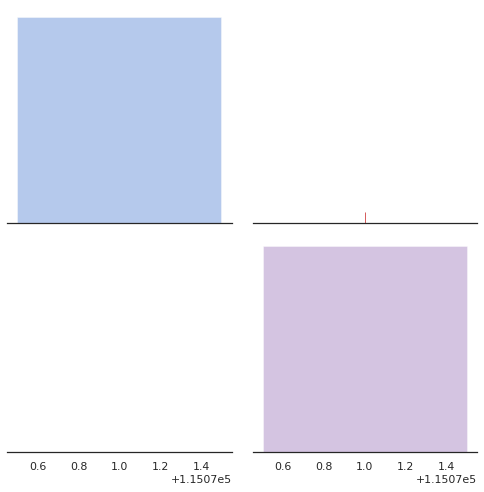

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

# Generate a random univariate dataset
d = len(train_df.songs.values.tolist())

# Plot a simple histogram with binsize determined automatically
sns.distplot(d, kde=False, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
sns.distplot(d, hist=False, rug=True, color="r", ax=axes[0, 1])

# Plot a filled kernel density estimate
sns.distplot(d, hist=False, color="g", kde_kws={"shade": True}, ax=axes[1, 0])

# Plot a histogram and kernel density estimate
sns.distplot(d, color="m", ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()

In [0]:
len(train_df.songs.values.tolist())

115071

In [0]:
def encoding_gnr(x): # 장르별 인코딩 함수
  encoded=Tokenizer.texts_to_sequences(x)
  encoding_list.append(np.concatenate(encoded)) ############# return value 로 고치는게 더 좋을거 같음 ##############
  

len(detail_gnr_list) # 세부장르 개수 단 Nan 제외 시켜야함

train_100_sam.updt_date.apply(encoding_gnr)  # 장르별 인코딩 # encoding_list 여기서 나옴
train_100_sam['encoding_gnr']=encoding_list



TypeError: ignored

In [0]:
# d

In [0]:
vectorizer = TfidfVectorizer()
tfidf_matrix =vectorizer.fit_transform(train_100_sam['updt_date'].apply(str))
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(train_100_sam.index, index=train_100_sam['id']).drop_duplicates()


In [0]:
for num,i in enumerate(cosine_sim):
  print("My index =", num)
  i_sort=sorted(i, reverse=True)
  for_multi_1=[ num2 for num2, x in enumerate( i ) if x == i_sort[0] ]
  print("앨범 index = ",for_multi_1,"코사인 유사도 = ",i_sort[0])  
  print("앨범 index = ",list(i).index(i_sort[1]),"코사인 유사도 = ",i_sort[1])
  print("앨범 index = ",list(i).index(i_sort[2]),"코사인 유사도 = ",i_sort[2])
  print("앨범 index = ",list(i).index(i_sort[3]),"코사인 유사도 = ",i_sort[3])

In [0]:


def index_basis_cosin(x): # x는 cosine_sim을 사용
  for_multi=[]
  # 코사인 유사도가 가장 높은 앨범을 상위 5개의 플레이리스트 인덱스 추출하는 코드 
  
  x_sort=sorted(x, reverse=True) # 내림차열
  x_sort=list(set(x_sort))
  
  for num1,value1 in enumerate(x_sort[0:6]): # 나를 포함한 가장 유사한 1~5등의 플레이리스트 중 
    cur_index=[ num2 for num2,value2 in enumerate( x ) if value2 == value1 ]  
    for_multi.append(cur_index)

  #for_multi=set(for_multi) # 유사도 1~5등까지의 인덱스 즉 위치
  #for_multi=np.concatenate(for_multi)
  return np.concatenate(for_multi)
  
def merge_playlist_by_index(x): # x 는 index_basis_cosin 결과 사용

  # 유사도 1~5등 까지의 인덱스 를 이용하여 playlist 와 tag 를 합치는 코드
  # 자기자신의 플레이 리스트 제외하고 총 100곡 이상 되도록
  # 자기자신의 테그 리스트 제외하고 총 10개 이상 되도록
  
  merge_song_list=[]
  for i in x:
    cur_song_list=train_100_sam.songs[i] # train_100_sam.songs[i] 는 노래id가 들어있는 list type
    merge_song_list.append(cur_song_list)

                                    
  #print("노래곡수 : ",len(list(set(merge_song_list))))
  return np.concatenate(merge_song_list)

In [0]:
qq=index_basis_cosin(cosine_sim[0])

In [0]:
qqq=[1,1,1,1,2,3,4]

print(set(qqq))
print(np.unique(qqq))

{1, 2, 3, 4}
[1 2 3 4]


In [0]:
qq

array([470, 137,  86, 931, 242, 650])

In [0]:
test=merge_playlist_by_index(qq)

In [0]:
len(list(set(test)))

165

In [0]:
Counter(test)

20-04-28 현재까지 문제점

1. 장르만 가지고 cosin 유사도 사용시 유사도 높은 playlist 를 합쳐도 겹치는 곡이 한곡밖에 없을 수 있음. => 추천이 제대로 못되고 있음

=> 장르와 함께 dtl 항목과 like , update 날짜를 활용해야함

해결방법

1. gnr , dtl 을 활용한 cosine 유사도를 구한다

2. 유사도 스코어 상위 5개에 해당하는 playlist 추린다.

3. 그 안에서 like_cnt 에 따라 우선순위로 100곡과 10개의 tag를 추천한다.

만약 이래도 점수가 낮으면 update 날짜 , cosine 유사도가 아닌 다른 방법 사용 ( 아마 knn 이 유력할거 같음 ) 




In [0]:
song_gnr_map

,id,song_gn_gnr_basket,song_gn_dtl_gnr_basket
0,0,[GN0900],[GN0901]
1,1,[GN1600],"[GN1601, GN1606]"
2,2,[GN0900],[GN0901]
3,3,[GN1100],"[GN1102, GN1101]"
4,4,[GN1800],"[GN1802, GN1801]"
...,...,...,...
707984,707984,[GN2000],[GN2001]
707985,707985,[GN0900],[GN0901]
707986,707986,[GN0100],"[GN0105, GN0101]"
707987,707987,[GN1800],"[GN1807, GN1801]"


In [0]:
gnr_code_tree['dtl_gnr_name'].to_list()

['세부장르전체',
 "'80",
 "'90",
 "'00",
 "'10-",
 '세부장르전체',
 "'80",
 "'90",
 "'00",
 "'10-",
 '세부장르전체',
 '랩 스타일',
 '보컬 스타일',
 '언더그라운드 힙합',
 '시대별',
 '세부장르전체',
 '어반',
 'R&B',
 '세부장르전체',
 '포크',
 '록',
 '일렉',
 '힙합',
 '발라드',
 "'90",
 "'00",
 "'10-",
 '세부장르전체',
 "'70",
 "'80",
 "'90",
 "'00",
 "'10-",
 '세부장르전체',
 '신세대트로트',
 '전설의트로트',
 '뽕짝트로트',
 '트로트메들리',
 "트로트'60-'70",
 "트로트'80-'90",
 "트로트'00-",
 "성인가요'80-'90",
 "성인가요'00-",
 '세부장르전체',
 "'60-'70",
 "'80-'90",
 "'00",
 "'10-",
 '세부장르전체',
 '얼터너티브팝',
 '올디스',
 '월드팝',
 "'60-'70",
 "'80-'90",
 "'00",
 "'10-",
 '세부장르전체',
 '모던록',
 '얼터너티브록',
 '프로그레시브/아트록',
 '하드록',
 '헤비메탈',
 '뉴메탈/하드코어',
 '포스트록',
 "'60",
 "'70",
 "'80",
 "'90",
 "'00",
 "'10-",
 '세부장르전체',
 '일렉트로니카',
 '하우스',
 '클럽뮤직',
 '일렉트로닉팝',
 "'80",
 "'90",
 "'00",
 "'10-",
 '세부장르전체',
 '팝랩',
 '얼터너티브힙합',
 '갱스터/하드코어랩',
 'East&West',
 "'80",
 "'90",
 "'00",
 "'10-",
 '세부장르전체',
 '컨템포러리 R&B',
 '소울',
 '어반',
 "'60-'70",
 "'80-'90",
 "'00",
 "'10-",
 '세부장르전체',
 '포크',
 '블루스',
 '컨트리',
 "'60-'70",
 "'80-'90",
 "'00-",

In [0]:
train_df.to_csv('melon.csv')

In [0]:
train_df

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,"[GN1400, GN0900, GN1000, GN1000, GN0900, GN100...","[525514, 129701, 383374, 562083, 297861, 13954...",71,"[GN1402, GN1401, GN0901, GN0902, GN1001, GN101..."
1,"[추억, 회상]",10532,"[GN0100, GN0600, GN0100, GN0600, GN0100, GN060...","[432406, 675945, 497066, 120377, 389529, 24427...",1,"[GN0101, GN0103, GN0601, GN0605, GN0104, GN010..."
2,"[까페, 잔잔한]",76951,"[GN0400, GN0400, GN0500, GN0600, GN0400, GN010...","[83116, 276692, 166267, 186301, 354465, 256598...",17,"[GN0401, GN0403, GN0401, GN0403, GN0501, GN060..."
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,"[GN1500, GN0900, GN2200, GN0100, GN0900, GN130...","[394031, 195524, 540149, 287984, 440773, 10033...",33,"[GN0908, GN1509, GN0901, GN2207, GN1501, GN150..."
4,[댄스],27616,"[GN0100, GN0100, GN2500, GN0200, GN0200, GN250...","[159327, 553610, 5130, 645103, 294435, 100657,...",9,"[GN0101, GN0101, GN0103, GN2502, GN2506, GN250..."
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


제출 및 평가 코드

In [0]:
!git clone https://github.com/kakao-arena/melon-playlist-continuation.git
!pip install fire

In [0]:
result_df_ref = pd.read_json('/content/arena_data/results/results.json', typ = 'frame')

In [0]:
!python melon-playlist-continuation/genre_most_popular.py run \
 	--song_meta_fname=./song_meta.json \
 	--train_fname=arena_data/orig/train.json \
 	--question_fname=./val.json

In [0]:
!python melon-playlist-continuation/evaluate.py evaluate \
	--gt_fname=arena_data/answers/val.json \
	--rec_fname=arena_data/results/results.json 